### 과대 적합
- 모델이 훈련 세트에서는 좋은 성능을 내나, 검증 세트에서 낮은 성능을 내는 경우
- 훈련 세트와 검증 세트에서 측정한 성능의 간격이 큰 경우
- 분산이 크다고 말함
- 모델이 훈련 세트에 집착하지 않도록 가중치 제한 -> 모델의 복잡도 낮춤

### 과소 적합
- 훈련 세트와 검증 세트에서 측정한 성능간 간격은 가깝지만, 성능 자체가 낮음
- 편향이 크다고 말함
- 모델이 충분히 복잡하지 않아 훈련 데이터의 패턴을 모두 잡아내지 못함
- 복잡도가 더 높은 모델을 사용하거나, 가중치의 규제를 완화하면 됨

### 에포크와 손실 함수의 그래프로 과대적합 및 과소적합 분석
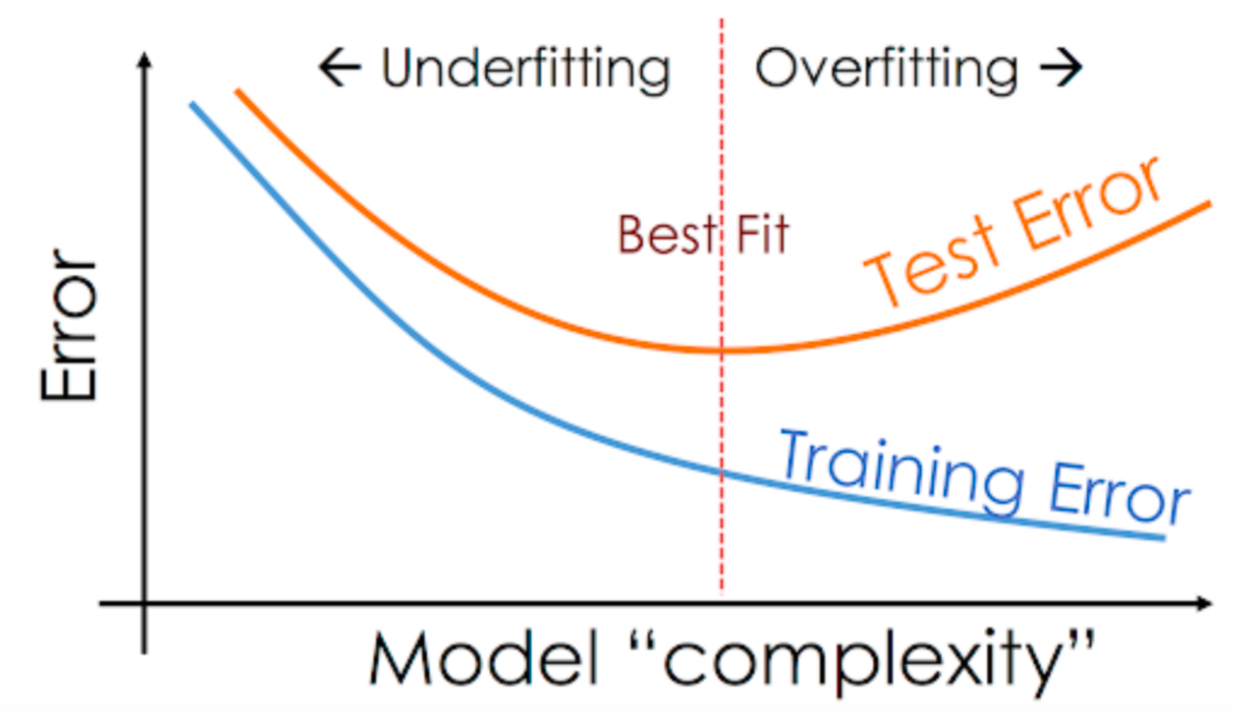

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)

In [2]:
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train_all, y_train_all)
sgd.score(x_test, y_test)

0.8333333333333334

In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


In [4]:
sgd = SGDClassifier(loss='log_loss', random_state=42)
sgd.fit(x_train, y_train)
sgd.score(x_val, y_val)

0.6923076923076923

In [8]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean) / train_std

In [5]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
class SingleLayer:
  def __init__(self, learning_rate=0.1):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z

  def backdrop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))

      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)
        w_grad, b_grad = self.backdrop(x[i], err)
        self.w -= self.lr * w_grad
        self.b -= self.lr * b_grad

        self.w_history.append(self.w.copy())

        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
      self.losses.append(loss/len(y))
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x] # 정방향 계산
    return np.array(z) > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i] * np.log(a) + (1-y_val[i]) * np.log(1-a))
    self.val_losses.append(val_loss/len(y_val))


In [9]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean) / val_std

In [10]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

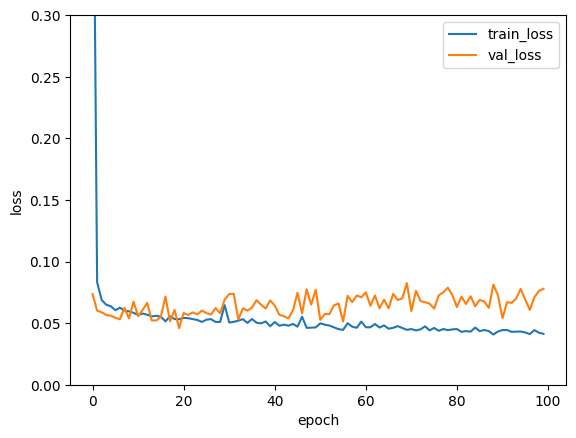

In [11]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

대략 20번째 에포크 이후 훈련 세트보다 검증 손실이 높아짐

In [12]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=20)
layer4.score(x_val_scaled, y_val)

np.float64(0.978021978021978)

## 규제 방법
- 가중치 규제란 가중치의 값이 커지지 않도록 제한하는 기법
- 모델이 몇 개의 데이터에 집착하면 새로운 데이터에 적응하지 못하므로 좋은 성능이라 할 수 없음 -> 모델이 일반화 되지 않았다고 일컫는다


## L1 규제
L1 규제는 손실 함수에 가중치의 절댓값인 L1 노름(norm)을 추가함
$$||w||_1=\sum_{i=1}^n |w_i|$$

$$w$$는 벡터를 의미함. 여기에서 L1 노름의 n은 가중치의 개수를 의미하므로 L1 규제를 '가중치의 절댓값을 손실 함수에 더한 것'으로 이해할 수 있다.

$$L=-(y\log (a) + (1-y)\log (1-a))$$
이는 로지스틱 손실 함수 여기에 L1 노름을 더하면 L1 규제가 되는 것
이때, 그냥 더하지 않고 규제의 양을 조절하는 파라미터 $$a$$를 곱한 후 더한다

$$L=-(y\log (a) + (1-y)\log (1-a)) + α\sum_{i=1}^n |w_i|$$

a는 L1 규제의 양을 조절하는 하이퍼파라미터이다. 예를 들어 a 값이 크면 전체 손실 함수의 값이 커지지 않도록 w 값의 합이 작아져야 한다. 이때 규제가 강해졌다고 표현한다. (가중치가 작아졌기 때문에)
반대로, a 값이 작으면 w의 합이 커져도 손실 함수의 값이 큰 폭으로 커지지 않는다. 규제가 약해진 것이다. 경사 하강법으로 가중치를 업데이트 하기 위해 L1 규제를 적용한 로지스틱 함수를 미분해보자



### L1 규제의 미분
절댓값 |w|를 w에 대해 미분하면 w 값의 부호만 남기 때문에(w가 양수면 1, 음수면 -1) w 값을 미분한 결과인 w의 부호라는 의미로 $$sign(w)$$ 라고 표현
L1 규제를 적용한 손실함수의 도함수는 다음과 같다
$$\frac{∂}{∂w}L = -(y-a)x+α\times sign(w)$$

가중치 벡터 w에 대한 미분으로 확장하여 식을 전개한다. 이 식을 가중치 업데이트 식에 적용하고 L1 규제에 학습률도 적용해보자. L1 규제를 적용한 손실 함수의 도함수에 합습률을 곱하면 된다

$$w=w-η\frac{∂L}{∂w}=w+η((y-a)x-α×sign(w))$$

L1 규제를 추가한 로지스틱 손실 함수를 경사 하강법으로 최적화 하려면, 규제 하이퍼파라미터 a와 가중치의 부호를 곱해서 업데이트할 그레디언트에 더해주면 된다. 파이썬 코드로는 다음과 같다

```python
w_grad += alpha * np.sign(w)
```

여기서 alpha 변수가 규제 하이퍼파라미터이다. np.sign() 함수는 배열 요소의 부호를 반환한다.  
하지만 이 식에서는 절편에 대해 규제를 하지 않는다. 절편은 모델에 영향을 미치는 방식이 가중치와 다르기 때문이다.
절편을 규제하면 모델을 특정 방향으로 이동 시킬 뿐 복잡도에는 영향을 끼치지 않는다 SGDClassifier 클래스에서는 penalty 매개변수를 사용하여 l1 규제를 적용할 수 있다. 또한 규제의 강도를 제어하는 하이퍼 파라미터 a를 위한 alpha 매개변수 또한 제공한다

**회귀 모델에 L1 규제를 추가한 것을 라쏘 모델이라 한다**
회귀 모델에도 같은 원리를 적용하여 손실 함수(제곱 오차)에 L1 규제를 적용할 수 있다 이런 모델을 라쏘라고 한다. 라쏘는 가중치를 줄이다 못해 일 부 가중치를 0으로 만들 수 있다
가중치가 0인 특성은 모델에서 사용할 수 없다는 것과 같은 의미  

미분 결과로 알 수 있듯, L1 규제는 규제 하이퍼파라미터 알파에 의존이 크다. 가중치 크기에 따라 규제의 양이 변하지 않으므로 규제 효과가 좋다고는 할 수 없다.

## L2 규제
L2 규제는 손실 함수에 가중치에 대한 L2 노름의 제곱을 더한다
$$||w||_2 = \sqrt{ \sum_{i=1}^n |w|^2} $$

손실 함수에 L2 노름의 제곱을 더하면 L2 규제가 된다. 이때 α는 L1 규제와 마찬가지로 규제의 양을 조절하기 위한 하이퍼파라미터로,
$$\frac{1}{2}$$는 미분결과를 보기 좋게 하기 위해 추가

$$L=-(y\log (a) + (1-y)\log(1-a)) + \frac{1}{2}α\sum_{i=1}^n |w_i|^2$$

### L2 규제의 미분
로지스틱 손실 함수의 미분은 이전과 같다. L2 규제를 미분하면 간단히 가중치 벡터 w만 남음
$$\frac{∂}{∂w}L = -(y-a)x+α×w$$
이 결과를 가중치 업데이트 식에 대입해보면,
$$w=w-η\frac{∂L}{∂w}=w+η((y-a)x-α×w)$$

L2 규제를 경사 하강법 알고리즘에 적용하면 그레디언트에 α와 가중치의 곱을 더하면 된다
```python
w_grad += alpha * w
```

L2 규제는 그레디언트 계산에 가중치의 값 자체가 포함되므로 가중치의 부호만 사용하는 L1 규제보단 효과적이다. 또 L2는 가중치를 0으로 만들지 않는다. 가중치를 완전히 0으로 만들면 특성을 제외하는 효과는 있지만 모델의 복잡도가 감소한다. 이런 이유로 L2 규제를 더 많이 사용한다



회귀 모델에 L2 규제를 적용한 것을 릿지 모델이라 함

사이킷런에서 릿지 모델을 `sklearn.linear_model.Ridge` 클래스로 제공한다
SGDClassifier 클래스에서는 penalty 매개변수를 l2로 지정하여 L2 규제를 추가할 수 있다
물론 두 클래스 모두 규제의 강도는 알파 매개변수로 제어한다

In [15]:
class SingleLayer:
  def __init__(self, learning_rate=0.1, l1=0, l2=0):
    self.w = None
    self.b = None
    self.losses = []
    self.val_losses = []
    self.w_history = []
    self.lr = learning_rate
    self.l1 = l1
    self.l2 = l2

  def forpass(self, x):
    z = np.sum(x * self.w) + self.b
    return z

  def backdrop(self, x, err):
    w_grad = x * err
    b_grad = 1 * err
    return w_grad, b_grad

  def activation(self, z):
    a = 1 / (1 + np.exp(-z))
    return a

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.w = np.ones(x.shape[1])
    self.b = 0
    self.w_history.append(self.w.copy())
    np.random.seed(42)
    for i in range(epochs):
      loss = 0
      indexes = np.random.permutation(np.arange(len(x)))

      for i in indexes:
        z = self.forpass(x[i])
        a = self.activation(z)
        err = -(y[i] - a)

        w_grad, b_grad = self.backdrop(x[i], err)

        # 그레디언트에서 패널티 항의 미분값 더하기
        w_grad += self.l1 * np.sign(self.w) + self.l2 * self.w

        self.w -= self.lr * w_grad
        self.b -= self.lr * b_grad

        self.w_history.append(self.w.copy())

        a = np.clip(a, 1e-10, 1-1e-10)
        loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
      self.losses.append(loss/len(y) + self.reg_loss())
      self.update_val_loss(x_val, y_val)

  def predict(self, x):
    z = [self.forpass(x_i) for x_i in x]
    return np.array(z) > 0

  def score(self, x, y):
    return np.mean(self.predict(x) == y)

  def update_val_loss(self, x_val, y_val):
    if x_val is None:
      return
    val_loss = 0
    for i in range(len(x_val)):
      z = self.forpass(x_val[i])
      a = self.activation(z)
      a = np.clip(a, 1e-10, 1-1e-10)
      val_loss += -(y_val[i] * np.log(a) + (1-y_val[i]) * np.log(1-a))
    self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

  # 손실함수 계산 시 패널티 항에 대한 값을 더해야 함
  def reg_loss(self):
    return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w ** 2)


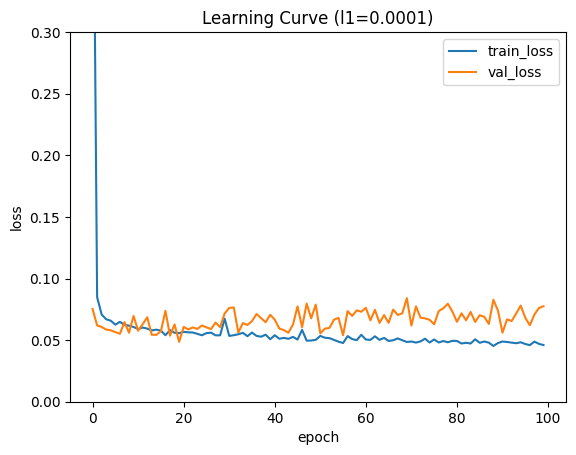

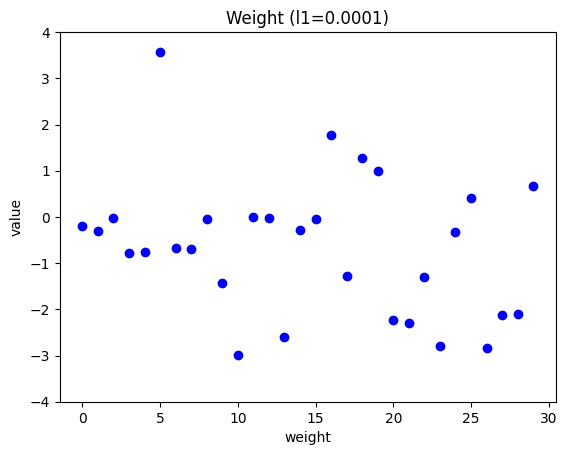

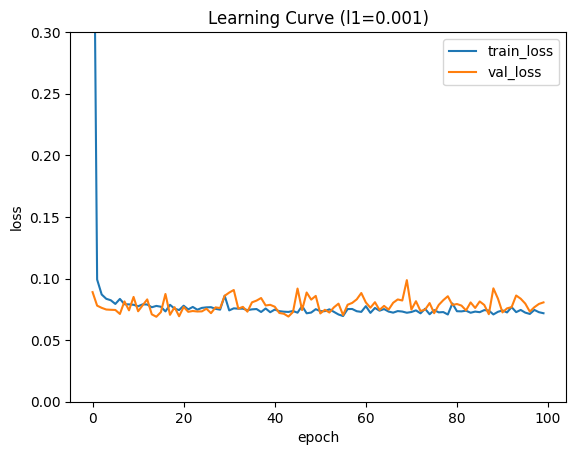

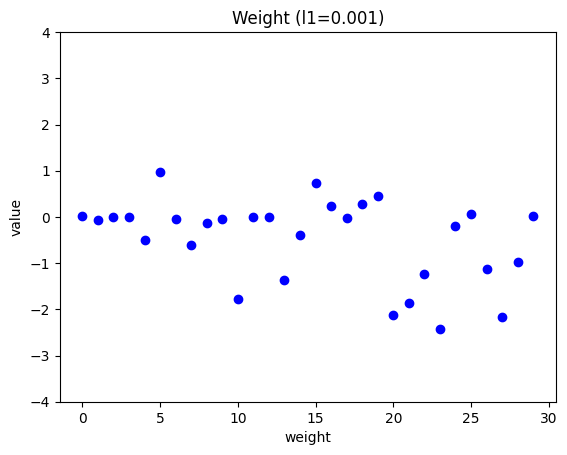

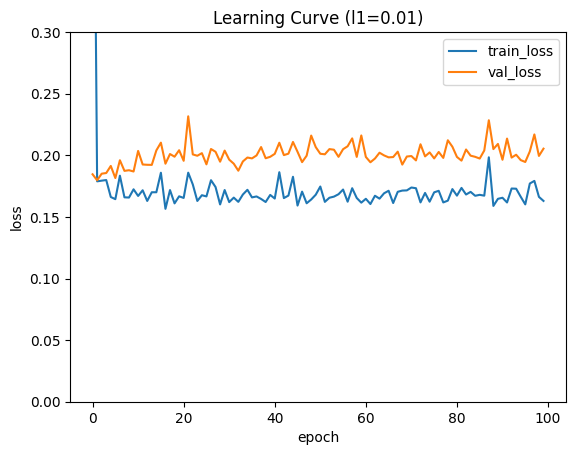

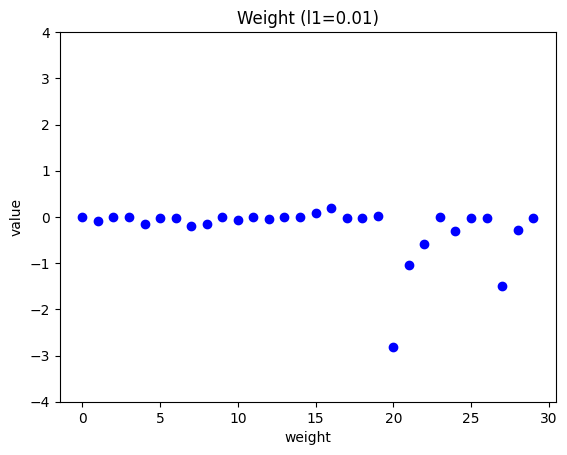

In [16]:
# L1 규제 강도에 따라 모델의 학습 곡선과 가중치 변화 살펴보기
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_list:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l1={})'.format(l1))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

In [17]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)


np.float64(0.978021978021978)

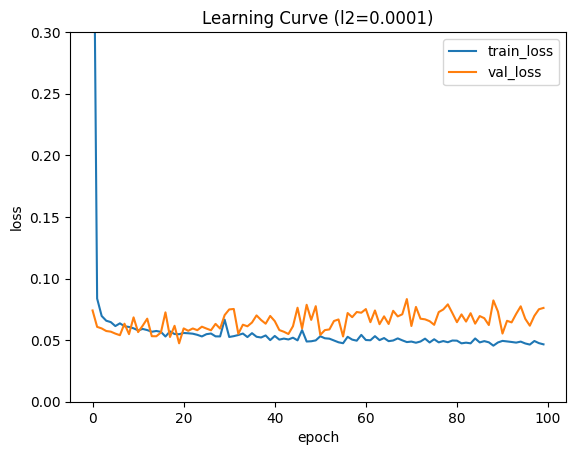

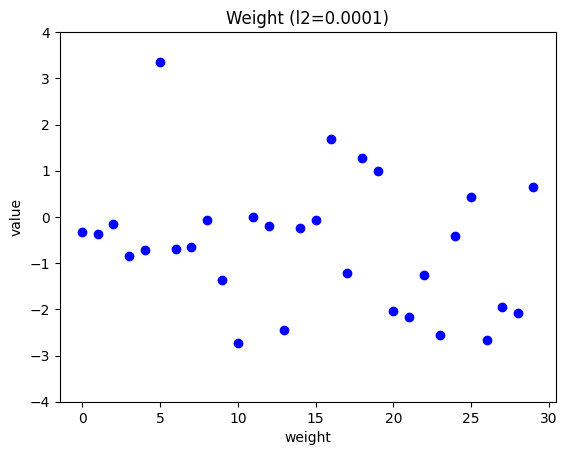

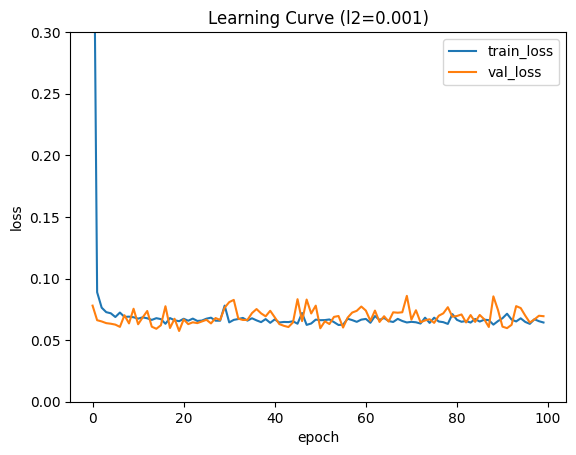

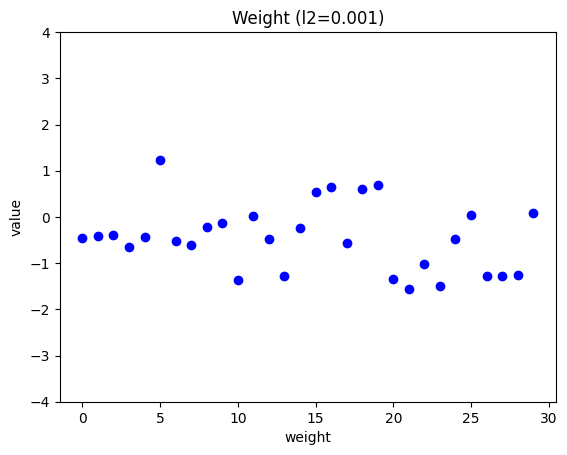

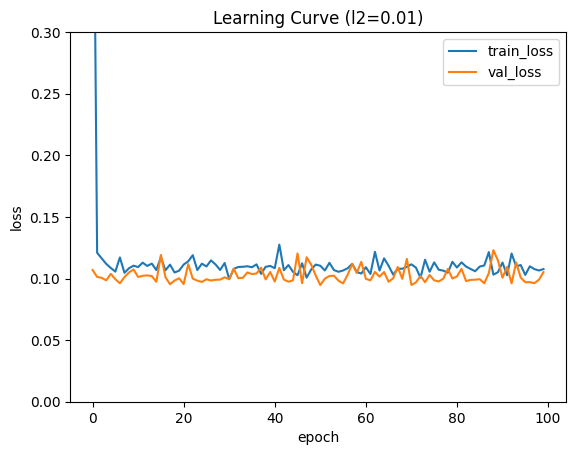

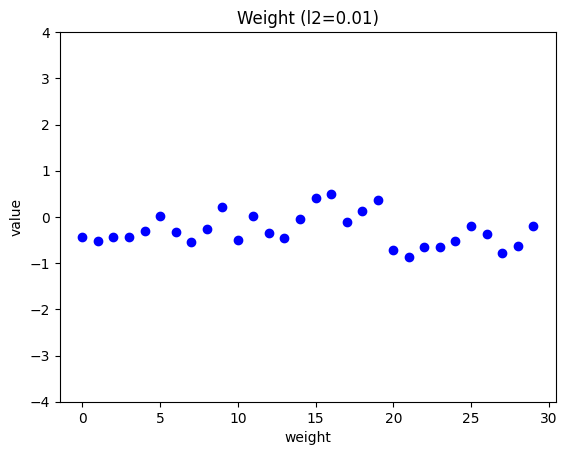

In [18]:
# L2 규제 강도에 따라 모델의 학습 곡선과 가중치 변화 살펴보기
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2={})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0, 0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.title('Weight (l2={})'.format(l2))
  plt.ylabel('value')
  plt.xlabel('weight')
  plt.ylim(-4, 4)
  plt.show()

In [20]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

np.float64(0.978021978021978)

In [21]:
np.sum(layer6.predict(x_val_scaled) == y_val)

np.int64(89)

In [22]:
#SGDClassifier에서 규제 적용하기
sgd = SGDClassifier(loss='log_loss', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

0.978021978021978